# Eksploracyjna analiza danych - na przykładzie danych z siłowni

## Wprowadzenie

Ten zestaw danych zapewnia szczegółowy przegląd rutynowych ćwiczeń członków siłowni, atrybutów fizycznych i wskaźników sprawności. Zawiera on 973 próbki danych z siłowni, w tym kluczowe wskaźniki wydajności, takie jak tętno, spalone kalorie i czas trwania treningu.
Każdy wpis zawiera również dane demograficzne i poziomy doświadczenia, co pozwala na kompleksową analizę wzorców sprawności, postępów sportowców i trendów zdrowotnych.

Główna zmienna zależna: `Workout_Type`

Inne istotne zmienne zależne: `Calories_Burned`, `Age`, `Gender`, `Water_Intake`, `Fat_Percentage` , `BMI`

Pytania zadawane do zbioru danych:

**Główne Pytania Badawcze:**
1. Czy istnieje korelacja między `Workout_Type` a jakąkolwiek zmienną
2. Jakie osoby chodzą na poszczególne typy zajęć?
3. Czy BMI i procentowa zawartość tłuszczu różni się między kobietami a mężczyznami ?


**Poboczne pytania:**
1. Jaki `Workout_Type` spala najwięcej kalorii/h?
2. Jak się zmienia `BMI` w zalezności ilości tkanki tłuszczowej?
3. Czy tętno spoczynkowe zmienia się wraz z wiekiem?
4. Czy osoby z większym procentem tkanki tłuszczowej szybciej spalają kalorie? 
5. Czy osoby z mniejszym procentem tkanki tłuszczowej piją więcej wody?

Import bibliotek użytych w projekcie oraz danych do analizy. Następnie przejrzenie informacji dostępnych w zbiorze:

In [32]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from correlation import mutual_info_numeric_cat, cramers_v_matrix,spearman_corr_numeric

path = Path.cwd() / 'silownia_new.csv'
df = pd.read_csv(path)

In [33]:
print(df.head())

    Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   NaN    Male         88.3        1.71      180      157           60   
1  46.0  Female         74.9        1.53      179      151           66   
2  32.0  Female         68.1        1.66      167      122           54   
3  25.0    Male         53.2        1.70      190      164           56   
4  38.0    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69             1313         Yoga            12.6   
1                      1.30              883          NaN            33.9   
2                      1.11              677       Cardio            33.4   
3                      0.59              532     Strength            28.8   
4                      0.64              556     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0        

In [25]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            873 non-null    float64
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    int64  
 9   Workout_Type                   823 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [26]:
print(df.describe(include=[np.number]))

              Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  873.000000   973.000000   973.00000  973.000000  973.000000   
mean    38.626575    73.854676     1.72258  179.883864  143.766701   
std     12.273464    21.207500     0.12772   11.525686   14.345101   
min     18.000000    40.000000     1.50000  160.000000  120.000000   
25%     28.000000    58.100000     1.62000  170.000000  131.000000   
50%     39.000000    70.000000     1.71000  180.000000  143.000000   
75%     50.000000    86.000000     1.80000  190.000000  156.000000   
max     59.000000   129.900000     2.00000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   973.000000                973.000000       973.000000      973.000000   
mean     62.223022                  1.256423       905.422405       24.976773   
std       7.327060                  0.343033       272.641516        6.259419   
min      50.000000                  0.500000 

## Czyszczenie i porządkowanie danych
Nasze dane posiadają 973 obserwacje i 15 kolumn.
Braki w danych są w kolumnach ['Age', 'Workout_Type', 'BMI']. 
Kolumnę BMI możemy obliczyć na podstawie wysokości i wagi. 
Problemem pozostał kolumny ['Age', 'Workout_Type']. Jest to 150 obserwacji 'Age' + 100 obserwacji 'Workout_Type'. 
Tylko w 14 obserwacjach pokrywa się brak 'Age' i 'Workout_type', co da nam 150+100-14=236 obserwacji z brakiem danych

##### Sprawdzanie kolumn z `nan`
Sprawdzamy konkretne *kolumny*, które mają wartości `nan`.  
Funkcja mapy cieplnej pokazuje, że nie ma silnych korelacji między brakującymi wartościami różnych cech. To dobrze dla naszych danych, niskie korelacje wskazują również, że dane są MAR (Missing At Random) i będzie możliwe ich uzupełnienie na podstawie reszty danych. 

In [27]:
print(df.shape)
print(df.duplicated().sum())

(973, 15)
0


In [34]:
nulls = df.isnull().sum()
print(nulls[nulls != 0].index.tolist())
print(nulls)
print(df[nulls[nulls != 0].index.tolist()].describe())


['Age', 'Workout_Type', 'BMI']
Age                              100
Gender                             0
Weight (kg)                        0
Height (m)                         0
Max_BPM                            0
Avg_BPM                            0
Resting_BPM                        0
Session_Duration (hours)           0
Calories_Burned                    0
Workout_Type                     150
Fat_Percentage                     0
Water_Intake (liters)              0
Workout_Frequency (days/week)      0
Experience_Level                   0
BMI                              150
dtype: int64
              Age         BMI
count  873.000000  823.000000
mean    38.626575   24.816549
std     12.273464    6.600485
min     18.000000   12.320000
25%     28.000000   20.105000
50%     39.000000   23.940000
75%     50.000000   28.450000
max     59.000000   47.720000


In [35]:
print(df['Age'].unique())
print(df['Workout_Type'].unique())
print(df['BMI'].unique())

[nan 46. 32. 25. 38. 56. 36. 40. 28. 41. 53. 57. 20. 39. 19. 47. 55. 50.
 42. 44. 59. 45. 33. 54. 24. 26. 35. 21. 52. 31. 34. 23. 43. 51. 27. 48.
 58. 18. 22. 29. 30. 49. 37.]
['Yoga' nan 'Cardio' 'Strength' 'HIIT']
[  nan 32.   18.41 14.39 20.55 23.76 30.57 32.34 30.07 43.31 17.89 43.4
 23.62 13.88 27.34 13.98 21.81 26.96 28.41 22.95 25.16 22.51 21.78 20.12
 17.6  24.54 27.64 33.4  25.83 27.84 42.63 24.37 33.14 19.11 17.77 21.4
 17.3  33.8  23.93 40.1  15.31 23.17 20.42 33.61 34.18 22.78 44.84 28.35
 21.77 20.86 16.99 22.45 16.86 32.93 17.11 22.28 25.89 33.55 19.72 39.12
 27.7  15.24 21.88 16.76 18.15 33.16 24.72 17.27 19.65 23.53 28.87 21.53
 19.42 29.71 22.89 29.61 29.53 27.85 22.31 30.3  22.15 37.56 18.76 15.7
 22.61 34.5  18.12 17.54 18.66 23.09 31.41 29.87 21.64 25.68 23.52 23.74
 16.52 20.88 30.52 26.65 24.16 29.26 30.54 29.95 21.41 17.88 34.24 22.43
 22.64 24.5  24.55 26.86 22.08 24.75 30.18 31.61 19.63 23.05 27.93 23.59
 13.23 28.97 26.1  20.06 38.78 16.04 12.47 27.01 22.69 39

In [36]:
x=df[df['Age'].isna()]
y=x[x['Workout_Type'].isna()]
y.shape


(14, 15)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


ValueError: could not convert string to float: '--'

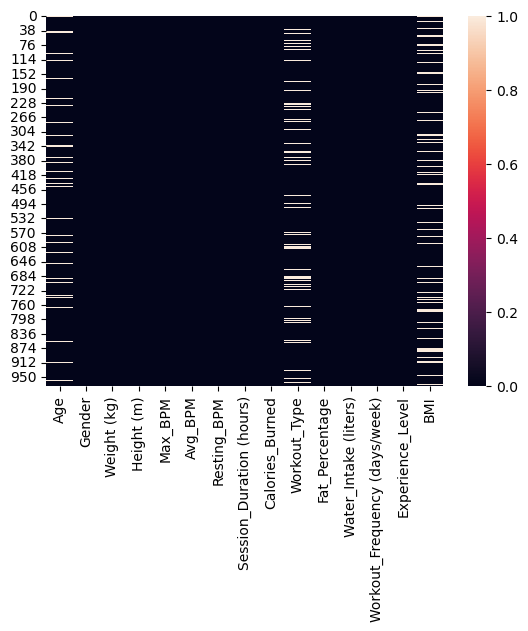

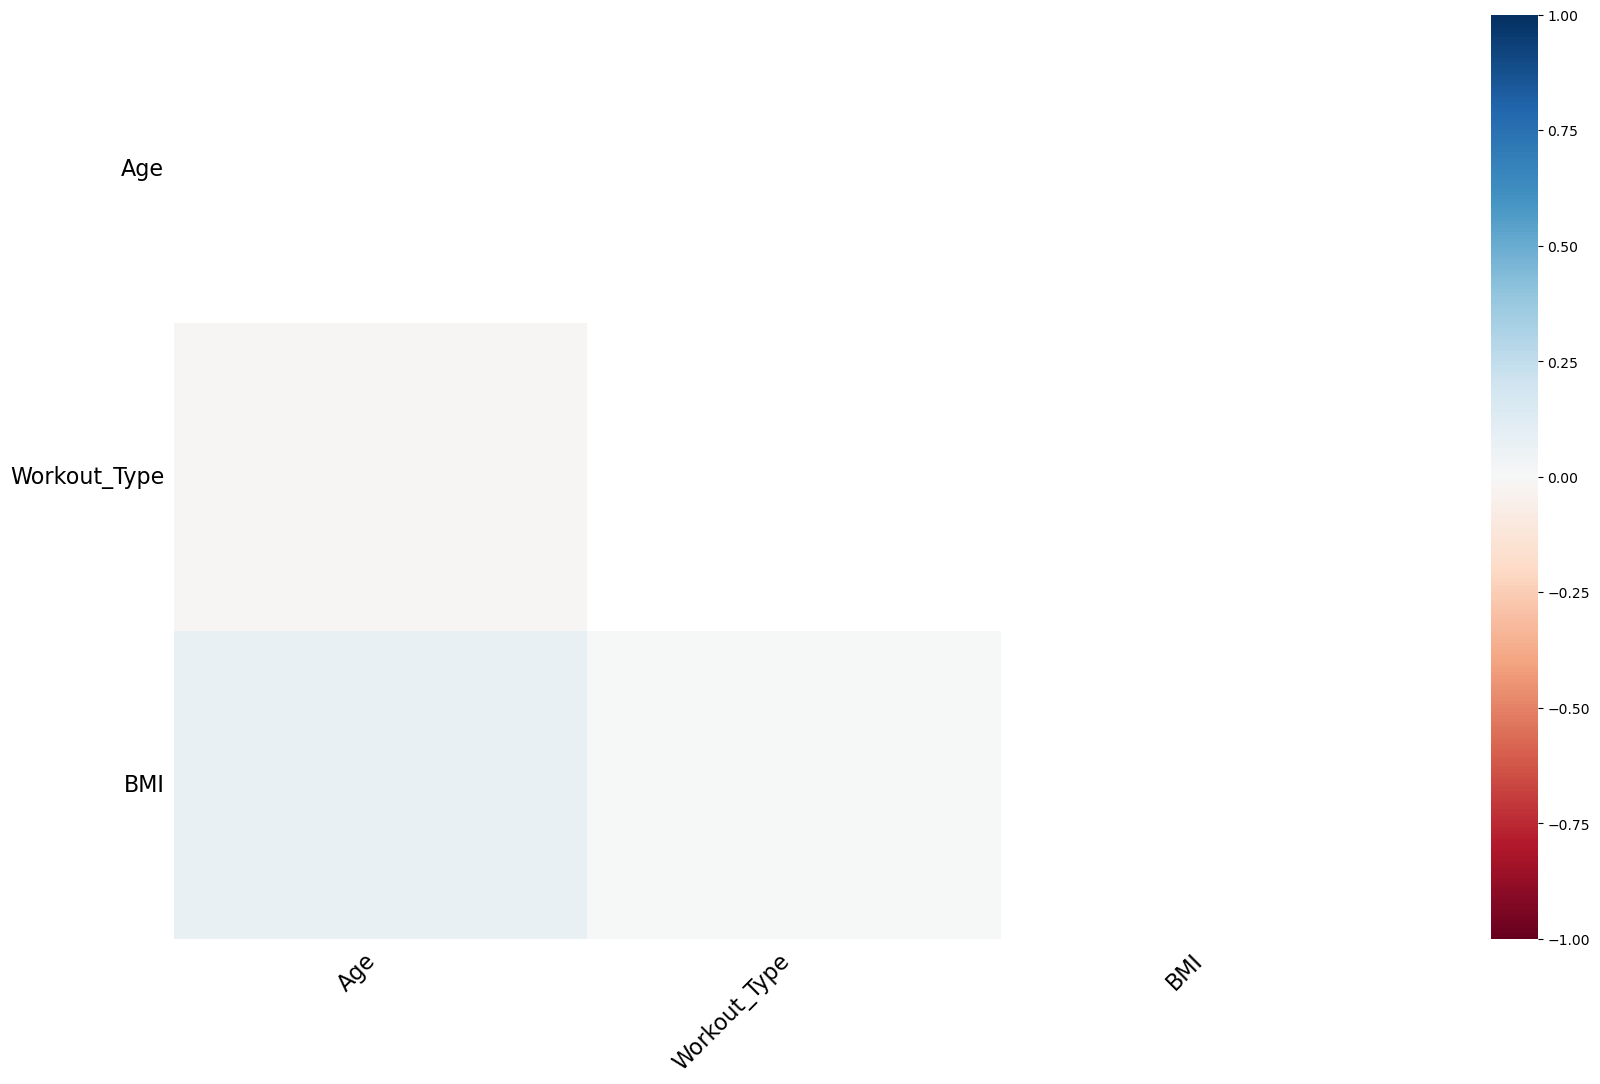

In [37]:
sns.heatmap(df.isna());
msno.heatmap(df);

#### Uzupełnijmy teraz brakujące dane dla kolumny z BMI:

In [38]:
BMI_braki = df['BMI'].isnull()
df.loc[BMI_braki, 'BMI'] = df.loc[BMI_braki, 'Weight (kg)'] / (df.loc[BMI_braki, 'Height (m)'] ** 2)
print(df.isnull()["BMI"].sum())


0


Zobaczmy macierz korelacji dla wszystkich zmiennych liczbowych. Pomoże nam to zdecydować, co zrobić z pozostałymi brakami.  

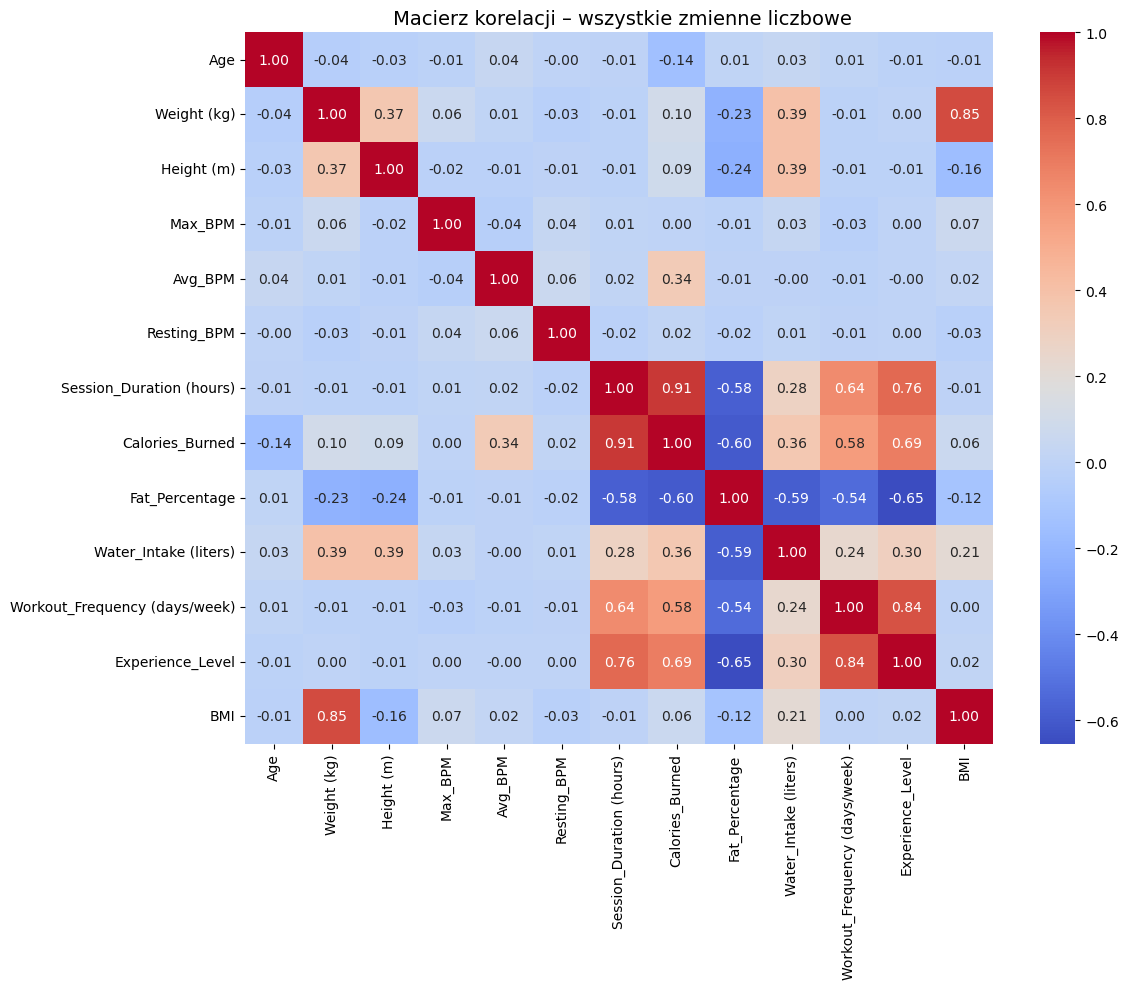

In [ ]:
#korelacje z weikiem
kor_matrix= df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(kor_matrix, annot=True, cmap="coolwarm",fmt=".2f")
plt.title(" Macierz korelacji – wszystkie zmienne liczbowe", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Imputacja wielokrotna dla braków:

In [39]:
from imputer import impute_with_mice
df_imputed = impute_with_mice(df, iterations=5)
df_imputed

,Age,Gender,Weight_kg,Height_m,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration_hours,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake_liters,Workout_Frequency_days_per_week,Experience_Level,BMI
0,49.0,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.197326
1,46.0,Female,74.9,1.53,179,151,66,1.30,883,Cardio,33.9,2.1,4,2,32.000000
2,32.0,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.713311
3,25.0,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.410000
4,38.0,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24.0,Male,87.1,1.74,187,158,67,1.57,1364,Strength,10.0,3.5,4,3,28.770000
969,25.0,Male,66.6,1.61,184,166,56,1.38,1260,Strength,25.0,3.0,2,1,25.693453
970,45.0,Female,60.4,1.76,194,120,53,1.72,929,Cardio,18.8,2.7,5,3,19.498967
971,32.0,Male,126.4,1.83,198,146,62,1.10,883,Yoga,28.2,2.1,3,2,37.740000


Porównujemy rozkład danych przed i po imputacji braków.
Takie uzupełnienie danych jest prawdopodobne i nie wpłynie na rozkład danych jak np. uzupełnienie braków średnią czy medianą.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Histogram Age PRZED imputacją
fig.add_trace(go.Histogram(
    x=df['Age'],
    name='Przed imputacją',
    marker_color='#e74c3c',
    opacity=0.6
))

# Histogram Age PO imputacji
fig.add_trace(go.Histogram(
    x=df_imputed['Age'],
    name='Po imputacji',
    marker_color='#2ecc71',
    opacity=0.6
))

# Ustawienia: nałożenie słupków
fig.update_layout(
    barmode='overlay',
    title='Porównanie rozkładu Age – przed i po imputacji',
    title_x=0.5,
    title_font_size=20,
    xaxis_title='Age',
    yaxis_title='Liczba obserwacji',
    template='plotly_white'
)

fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Histogram Workout_Type PRZED imputacją
fig.add_trace(go.Histogram(
    x=df['Workout_Type'],
    name='Przed imputacją',
    marker_color='#e74c3c',
    opacity=0.6
))

# Histogram Workout_Type PO imputacji
fig.add_trace(go.Histogram(
    x=df_imputed['Workout_Type'],
    name='Po imputacji',
    marker_color='#2ecc71',
    opacity=0.6
))

# Ustawienia: nałożenie słupków
fig.update_layout(
    barmode='overlay',
    title='Porównanie rozkładu Workout_Type – przed i po imputacji',
    title_x=0.5,
    title_font_size=20,
    xaxis_title='Workout_Type',
    yaxis_title='Liczba obserwacji',
    template='plotly_white'
)

fig.show()


#### Analiza wartości odstających:
W kolumnach "Weight_kg", "Calories_burned" i "BMI" zaobserwowano występowanie outlierów. Ich obecność wydaje się być realna- nie stwierdzono błędów w danych. 


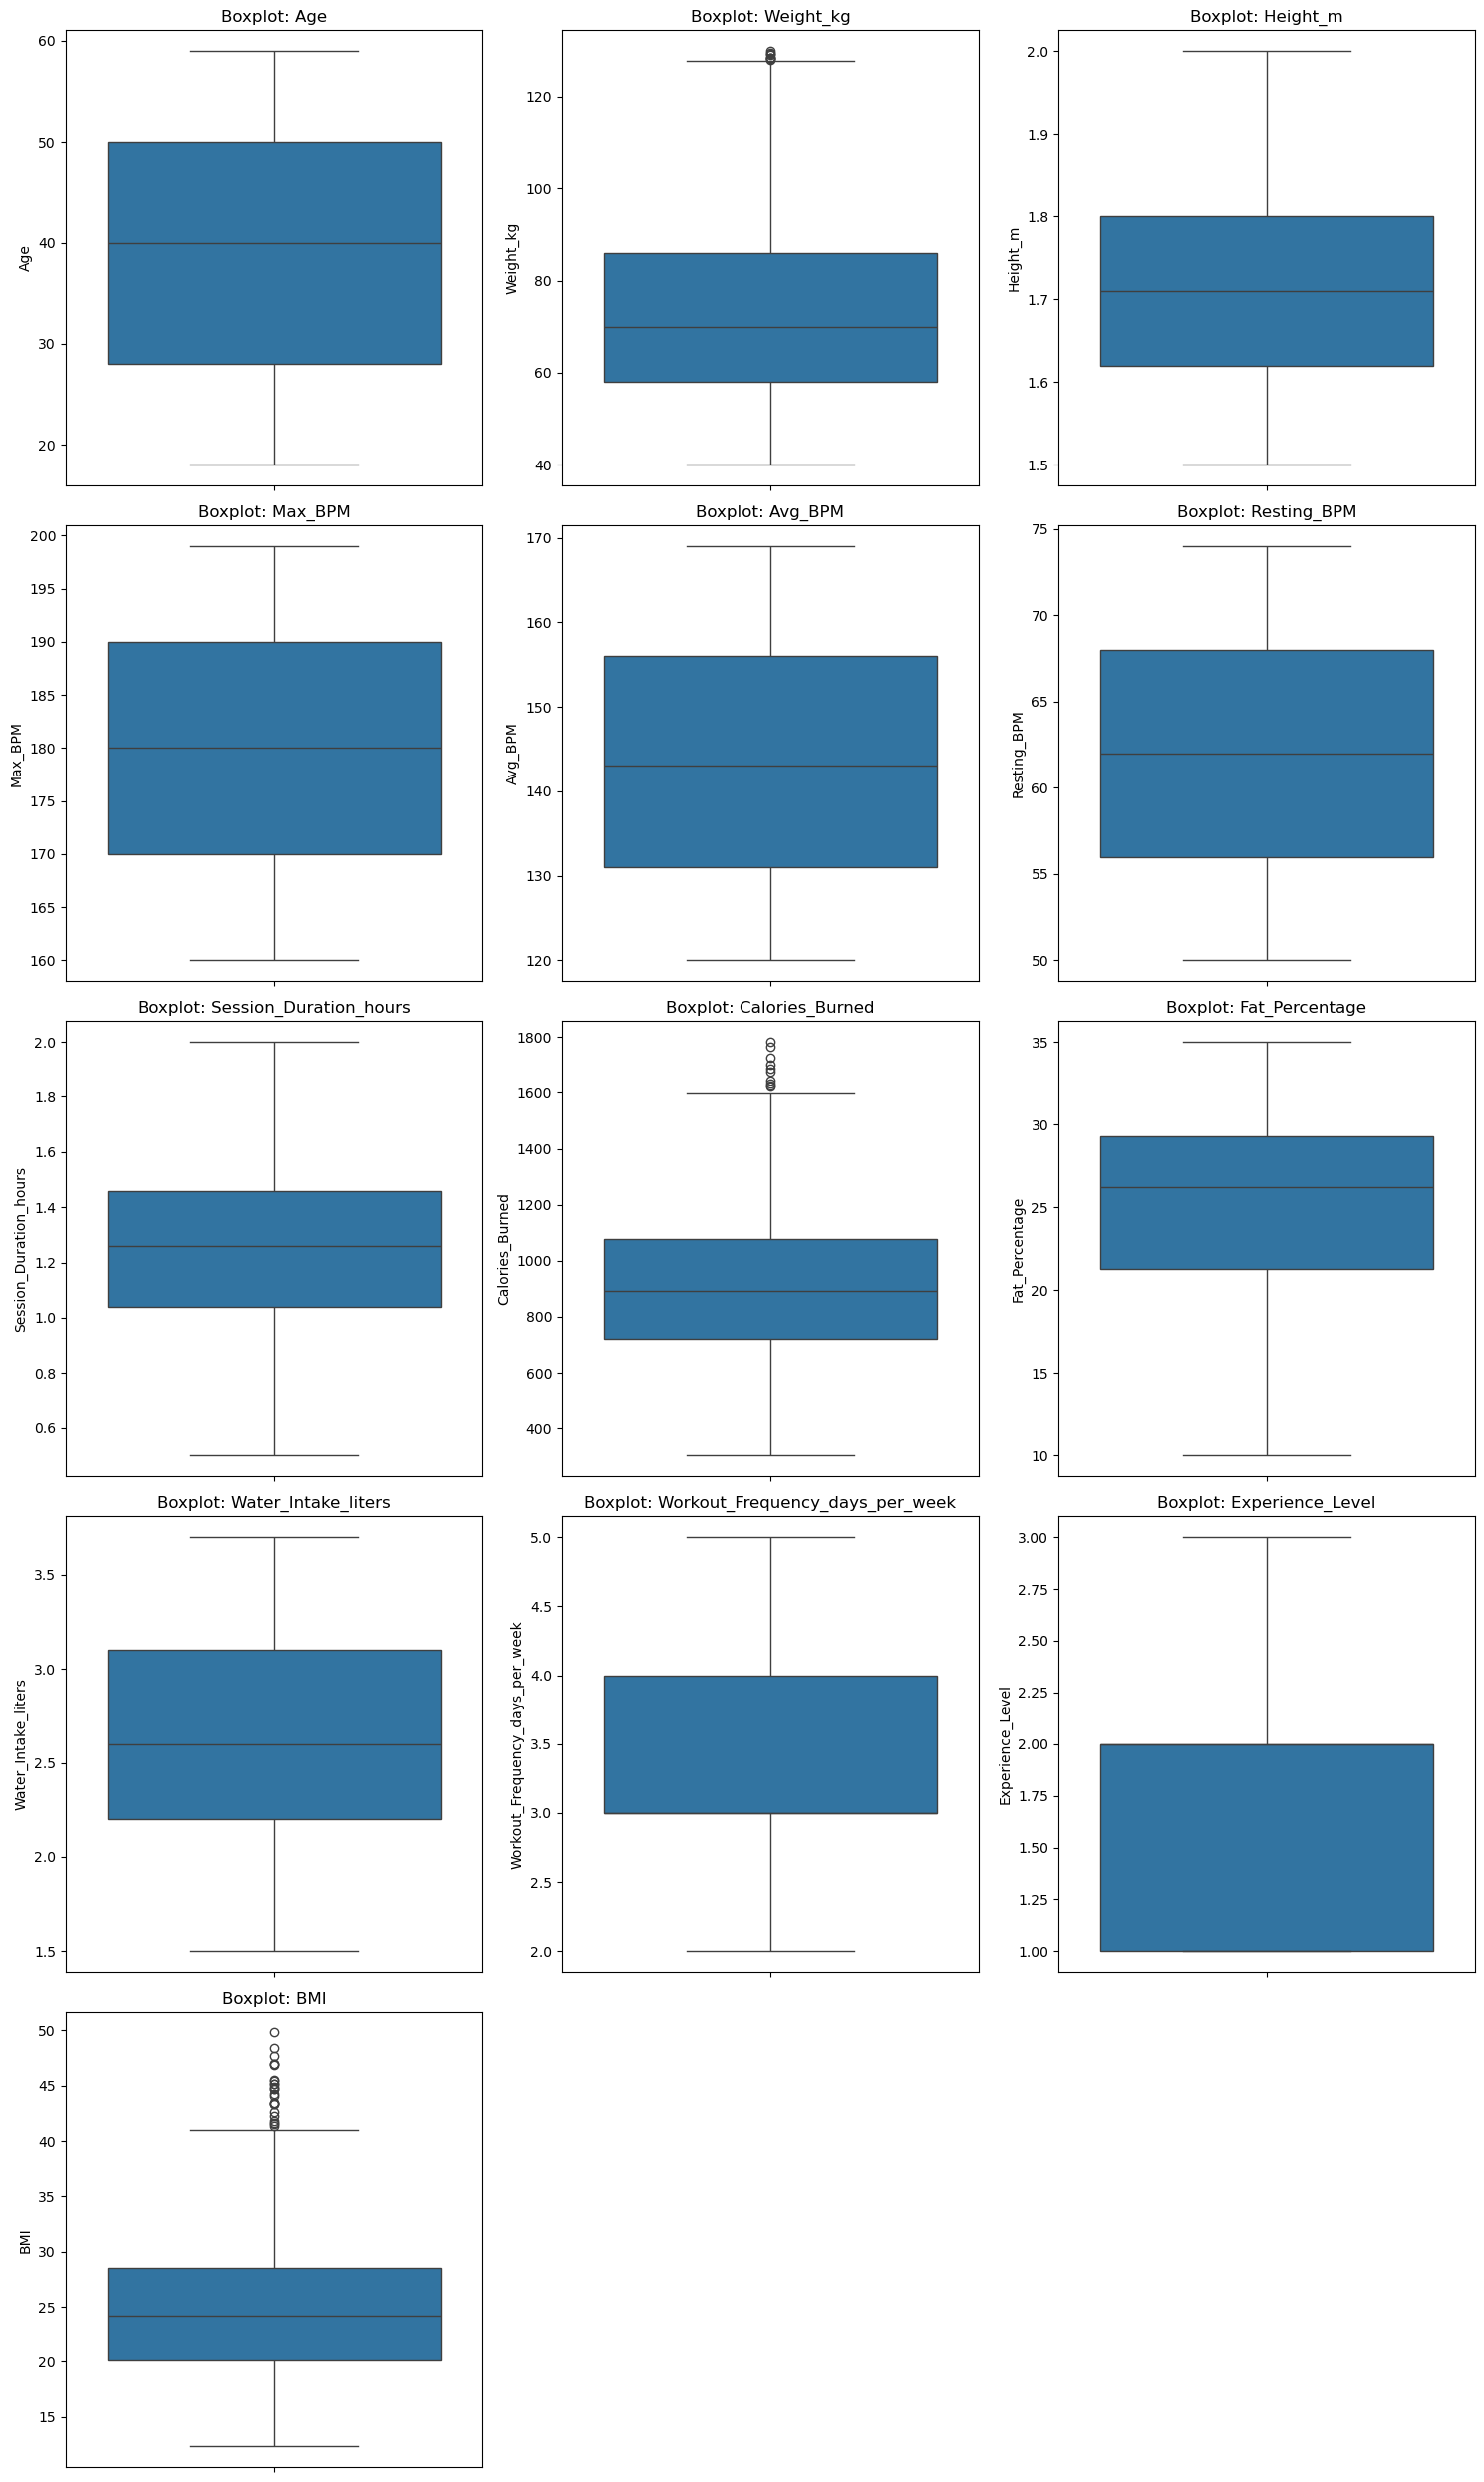

In [ ]:
numeric_cols = df_imputed.select_dtypes(include=['number']).columns

# Rozmiar siatki wykresów
plt.figure(figsize=(15, 5 * ((len(numeric_cols) + 2) // 3)))

# Tworzenie boxplotów
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i + 1)
    sns.boxplot(data=df_imputed[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.show()

## Wizualizacje

W wykresie poniżej widać częściowo "naprzemienny" rozkład procent tłuszczu w zależności od płci. Może to wynikać z przygotowania przez autora danych wejściowych. 

Kobiety mają też częściej większy udział tkanki tłuszczowej w masie ciała, za to największe wartości BMI należą do mężczyzn.

In [ ]:
fig = px.scatter(
    df_imputed,
    x='BMI',
    y='Fat_Percentage',
    # size='Calories_Burned',
    color='Gender',
    opacity=0.7,
    title='BMI a procent tkanki tłuszczowej',
    size_max=60
)

fig.update_traces(textposition='middle center')
fig.show()


Poniższy wykres Gęstości BMI w zależnosci od płci pokazuje, że BMI kobiet chodzących na siłownie jest silnie skupione (std = 4.4) wokół mediany = 22.875.
BMI mężczyzn jest mniej skupione (std = 7.6) wokół mediany  26.220 .

Ujemne Kurtozy wskazują na Krzywa platykurtyczna rozkladu BMI dla obu płci.
W porównaniu do rozkładu normalnego, ich  centralny szczyt jest niższy i szerszy, a jego ogony są krótsze i cieńsze.

Dla mężczyzn (Male), kurtoza = -0.17

Dla kobiet (Female), kurtoza = -0.53

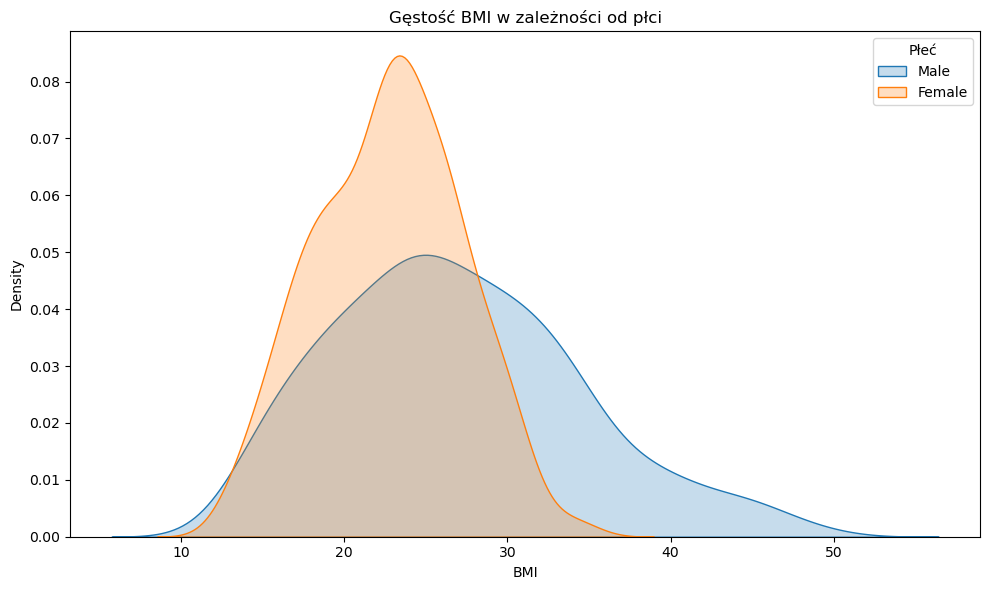

In [ ]:
plt.figure(figsize=(10, 6))
for wt in df_imputed['Gender'].dropna().unique():
    sns.kdeplot(df_imputed[df_imputed['Gender'] == wt]["BMI"], label=wt, fill=True)

plt.title("Gęstość BMI w zależności od płci")
plt.xlabel("BMI")
plt.legend(title='Płeć')
plt.tight_layout()
plt.show()

In [ ]:
group_stats = df_imputed.groupby('Gender')['BMI'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
print(group_stats)

        count       mean  median       std    min        max
Gender                                                      
Female    462  22.727796  22.925  4.475426  12.47  35.040000
Male      511  26.886980  26.220  7.630526  12.32  49.843756


In [ ]:
from scipy.stats import kurtosis

for gender in df_imputed['Gender'].dropna().unique():
    bmi_values = df_imputed[df_imputed['Gender'] == gender]['BMI'].dropna()
    k = kurtosis(bmi_values, fisher=True)
    print(f"Kurtoza BMI dla płci {gender}: {k:.2f}")

Kurtoza BMI dla płci Male: -0.17
Kurtoza BMI dla płci Female: -0.53


Kobiety w wieku około 50 lat preferują HIIT (High Intensity Interval Training),
Strenght i Yoga jest porównywalnie popularny w grupach kobiet  20-30 oraz 40-50.
Cardio jest popularne zwłaszcza u kobiet w wieku 30-40 lat. 

Mężczyźni w wieku około 40 lat wybierają najczęściej ćwiczenia Cardio.
W wieku 40-50 lat wzrasta zainteresowanie Strength jak i Jogą.

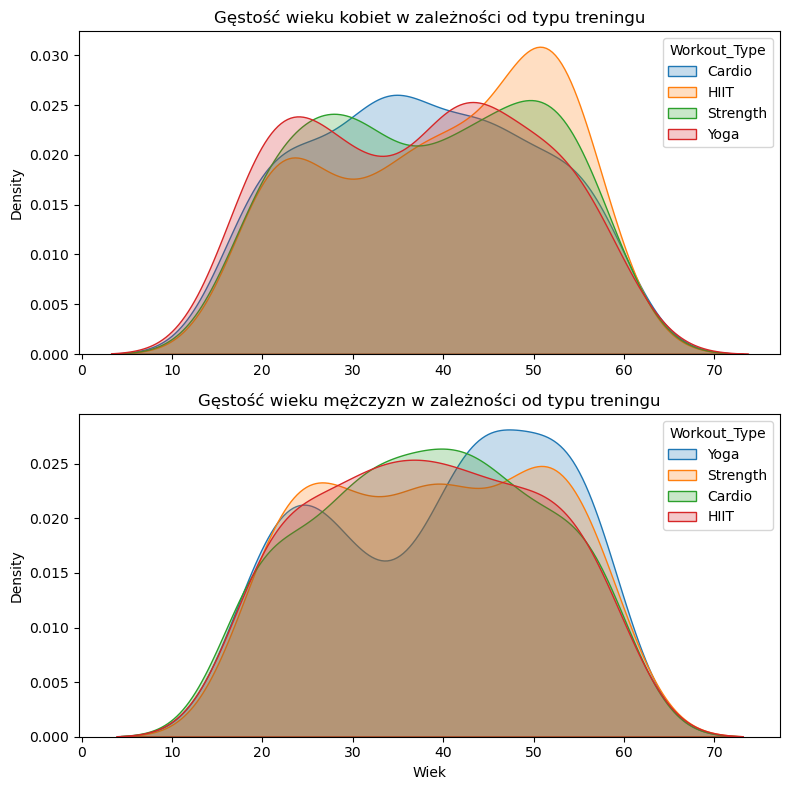

In [ ]:

# Dane
female_data = df_imputed[df_imputed['Gender'] == 'Female']
male_data = df_imputed[df_imputed['Gender'] == 'Male']

# Tworzymy figurę z 2 wykresami (jeden pod drugim)
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# 1. Wykres dla kobiet
for wt in female_data['Workout_Type'].dropna().unique():
    sns.kdeplot(
        female_data[female_data['Workout_Type'] == wt]['Age'],
        label=wt,
        fill=True,
        ax=axes[0]
    )
axes[0].set_title("Gęstość wieku kobiet w zależności od typu treningu")
axes[0].set_xlabel("Wiek")
axes[0].legend(title='Workout_Type')
axes[0].tick_params(labelbottom=True)

# 2. Wykres dla mężczyzn
for wt in male_data['Workout_Type'].dropna().unique():
    sns.kdeplot(
        male_data[male_data['Workout_Type'] == wt]['Age'],
        label=wt,
        fill=True,
        ax=axes[1]
    )
axes[1].set_title("Gęstość wieku mężczyzn w zależności od typu treningu")
axes[1].set_xlabel("Wiek")
axes[1].legend(title='Workout_Type')

plt.tight_layout()
plt.show()


In [ ]:
grouped_stats = df_imputed.groupby(['Gender', 'Workout_Type'])['Age'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()

# Zaokrąglamy dla czytelności
grouped_stats = grouped_stats.round(2)

# Wyświetlenie
print(grouped_stats)

   Gender Workout_Type  count   mean  median    std   min   max    q1     q3  \
0  Female       Cardio    127  37.71    37.0  12.23  18.0  59.0  27.5  46.00   
1  Female         HIIT    103  39.82    41.0  12.32  19.0  58.0  29.0  50.50   
2  Female     Strength    122  38.39    39.5  12.33  18.0  59.0  28.0  50.00   
3  Female         Yoga    110  37.29    39.5  12.58  18.0  59.0  25.0  47.75   
4    Male       Cardio    132  38.43    38.5  12.11  18.0  59.0  29.0  48.00   
5    Male         HIIT    110  38.35    38.0  12.08  18.0  59.0  29.0  48.75   
6    Male     Strength    132  38.98    39.0  12.33  18.0  59.0  28.0  50.00   
7    Male         Yoga    137  39.81    43.0  12.58  18.0  59.0  28.0  50.00   

     iqr  
0  18.50  
1  21.50  
2  22.00  
3  22.75  
4  19.00  
5  19.75  
6  22.00  
7  22.00  


Poniższy wykres pokazuje ilość kobiet i mężczyzn chodząca na poszczegolne zajęcia.
Najpopularnijszy wśród kobiet jest Strething, natomiast u mezczyzn Cardio

In [45]:
import plotly.express as px

# Zakładamy, że df_imputed ma kolumny: Workout_Type i Sex

# Grupujemy dane
counts = df_imputed.groupby(['Workout_Type', 'Gender']).size().reset_index(name='Count')

# Tworzymy wykres słupkowy
fig = px.bar(
    counts,
    x='Workout_Type',
    y='Count',
    color='Gender',
    text='Count',
    title='Liczba osób wykonujących ćwiczenia z podziałem na płeć',
    labels={'Workout_Type': 'Typ ćwiczenia', 'Count': 'Liczba osób'}
)

# Styl: wartości nad słupkami i estetyka
fig.update_traces(textposition='outside')
fig.update_layout(barmode='stack', xaxis_tickangle=-45)  # Możesz zmienić na 'group' zamiast 'stack'

fig.show()


Zauważono wzrost tętna spoczynkowego w grupie wiekowej 46-55 lat. Za to po tym wieku tętno spoczynkowe zaczyna maleć. 

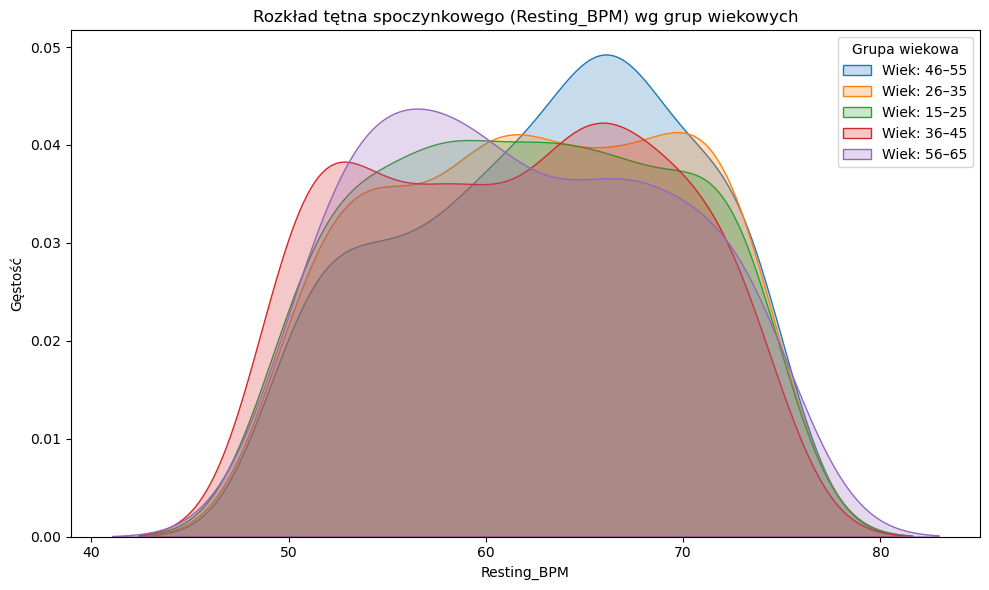

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Tworzymy kategorie wiekowe
df_imputed['Age_Group'] = pd.cut(df_imputed['Age'], bins=[15, 25, 35, 45, 55, 65, 80],
                                  labels=['15–25', '26–35', '36–45', '46–55', '56–65', '66+'])

# Wykres KDE tętna spoczynkowego w zależności od grupy wiekowej
plt.figure(figsize=(10, 6))
for group in df_imputed['Age_Group'].dropna().unique():
    sns.kdeplot(df_imputed[df_imputed['Age_Group'] == group]['Resting_BPM'], 
                label=f'Wiek: {group}', fill=True)

plt.title("Rozkład tętna spoczynkowego (Resting_BPM) wg grup wiekowych")
plt.xlabel("Resting_BPM")
plt.ylabel("Gęstość")
plt.legend(title="Grupa wiekowa")
plt.tight_layout()
plt.show()


# Analiza opisowa<br>

### Wnioski z korelacji Pearsona
Zmienne badane: Calories_Burned, Age, Gender, Water_Intake, Fat_Percentage , BMI


- **Skład ciała i nawyki zdrowotne:**
  - `Fat_Percentage` ma umiarkowanie silną ujemną korelację z `Calories_Burned` (-0.60), `Session_Duration` (-0.58) oraz `Workout_Frequency` (-0.54), co sugeruje, że osoby z większą aktywnością mają tendencję do niższego procentu tłuszczu.
  
  - `Water_Intake (liters)` jest umiarkowanie dodatnio skorelowany z `BMI`, co wskazuje na wyższe spożycie wody u osób większych.

- **Tętno (BPM):**
  - `Max_BPM`, `Avg_BPM` i `Resting_BPM` mają bardzo słabe korelacje z innymi zmiennymi (wartości bliskie zeru), co sugeruje, że tętno jest niezależne od reszty badanych cech w tym zestawie danych.

- **Wiek (Age):**
  - Korelacje wieku z innymi zmiennymi są bardzo słabe, co wskazuje na brak wyraźnych liniowych powiązań wieku z resztą cech.


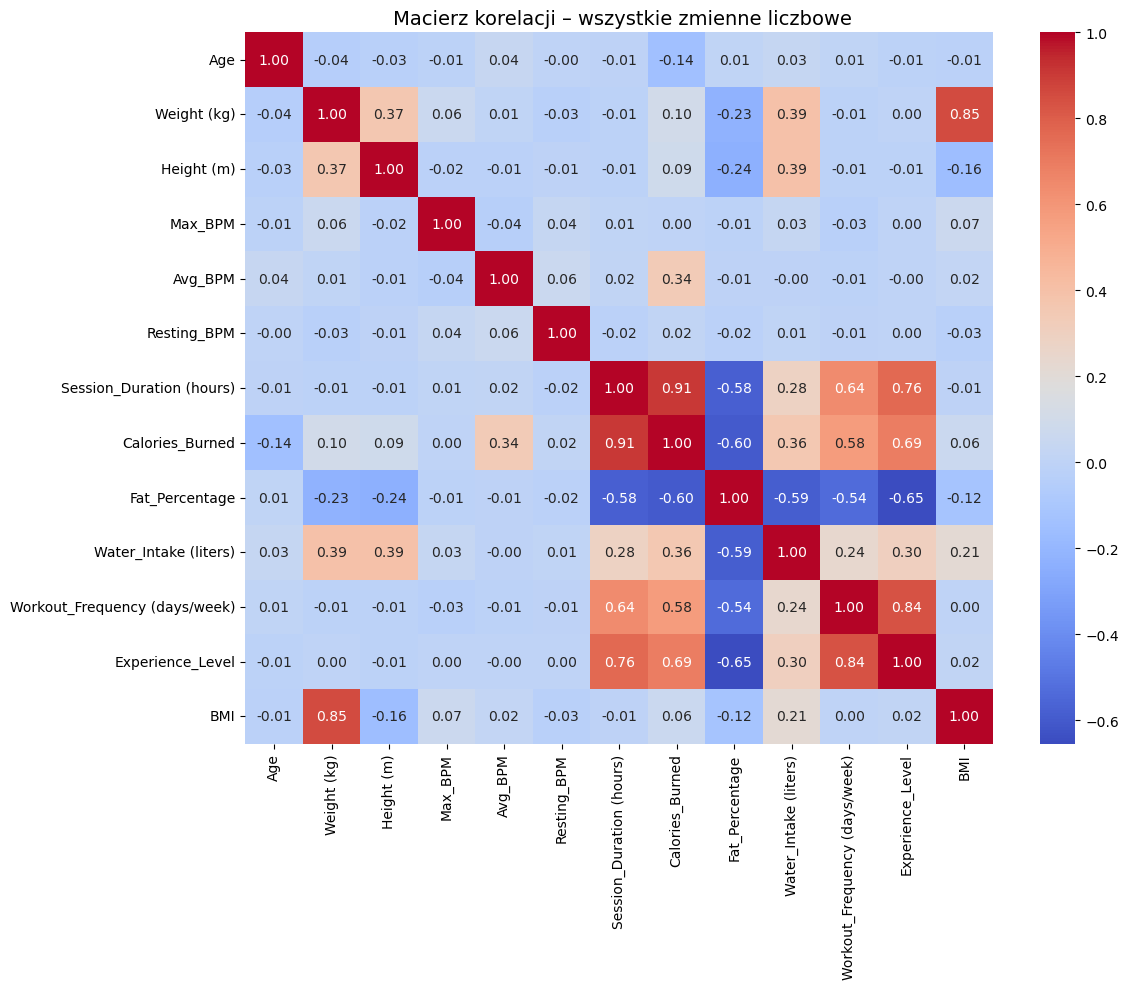

In [ ]:
kor_matrix= df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(kor_matrix, annot=True, cmap="coolwarm",fmt=".2f")
plt.title(" Macierz korelacji – wszystkie zmienne liczbowe", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
kor_matrix

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
Age,1.000000,-0.040981,-0.031973,-0.013422,0.037770,-0.000306,-0.006264,-0.144239,0.006703,0.033994,0.005841,-0.013960,-0.014782
Weight (kg),-0.040981,1.000000,0.365321,0.057061,0.009717,-0.032138,-0.013666,0.095443,-0.225512,0.394276,-0.011769,0.003379,0.853156
Height (m),-0.031973,0.365321,1.000000,-0.017660,-0.014776,-0.005090,-0.010206,0.086348,-0.235521,0.393533,-0.011270,-0.010267,-0.159471
Max_BPM,-0.013422,0.057061,-0.017660,1.000000,-0.039751,0.036647,0.010051,0.002090,-0.009056,0.031621,-0.029099,0.000545,0.067111
Avg_BPM,0.037770,0.009717,-0.014776,-0.039751,1.000000,0.059636,0.016014,0.339659,-0.007302,-0.002911,-0.010681,-0.000888,0.021609
Resting_BPM,-0.000306,-0.032138,-0.005090,0.036647,0.059636,1.000000,-0.016649,0.016518,-0.016834,0.007726,-0.007967,0.001758,-0.032531
Session_Duration (hours),-0.006264,-0.013666,-0.010206,0.010051,0.016014,-0.016649,1.000000,0.908140,-0.581520,0.283411,0.644140,0.764768,-0.006494
Calories_Burned,-0.144239,0.095443,0.086348,0.002090,0.339659,0.016518,0.908140,1.000000,-0.597615,0.356931,0.576150,0.694129,0.059762
Fat_Percentage,0.006703,-0.225512,-0.235521,-0.009056,-0.007302,-0.016834,-0.581520,-0.597615,1.000000,-0.588683,-0.537060,-0.654363,-0.119258
Water_Intake (liters),0.033994,0.394276,0.393533,0.031621,-0.002911,0.007726,0.283411,0.356931,-0.588683,1.000000,0.238563,0.304104,0.213691


Z poniższych wykresów możemy wywnioskować, że istnieje zależność liniowa między procentem tłuszczu w organizmie a ilością spalanych kalorii. Osoby z większą tkanką tłuszczową spalaja mniej kcal. 

Wszystkie osoby mające tkankę tłuszczową w zakresie 10-15% piją 3,5 l wody dziennie. Poza tą grupą widać zależność procent tłuszczu do ilości wypitej wody- osoby posiadające mniejszą tkankę tłuszczową częściej piją większe ilości wody. 

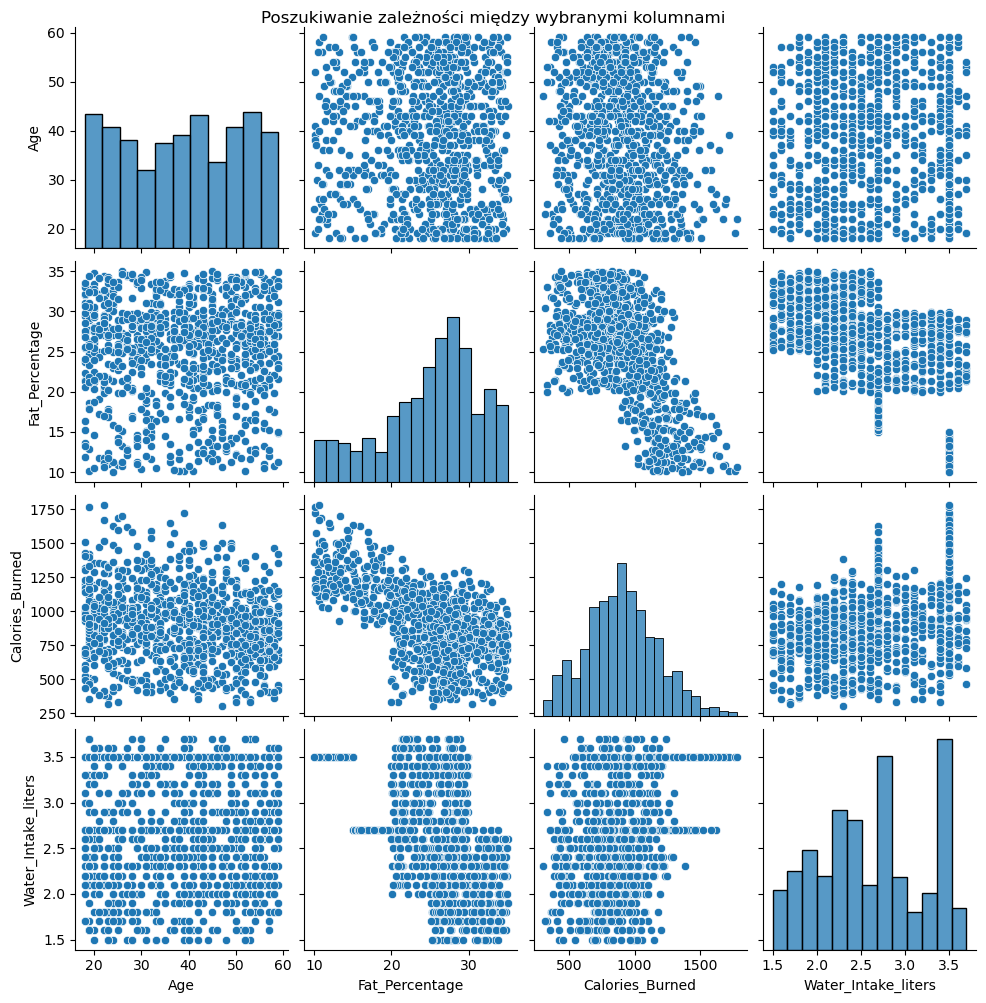

In [ ]:
sns.pairplot(df_imputed, vars=['Age', 'Fat_Percentage', 'Calories_Burned', 'Water_Intake_liters'])
plt.suptitle("Poszukiwanie zależności między wybranymi kolumnami", y=1)
plt.show()

## V Cramer'a <br>
HO: Nie stnieje korelacja Cramer'a pomiędzy wartościami kategorycznymi '`Gender`', '`Workout_Type`' <br>
HA: Istnieje korelacja Cramér’a pomiędzy wartościami kategorycznymi '`Gender`' i '`Workout_Type`'. <br>

Result:<br>
p-value: 0.55 > 0 -> brak dowodów, żeby odrzucić hipotezę zerową (H0). <br>

Nie ma statystycznie istotnej korelacji między '`Gender`' a '`Workout_Type`'.


In [ ]:
from scipy.stats import chi2_contingency

tab = pd.crosstab(df['Gender'], df['Workout_Type'])
chi2, p, dof, ex = chi2_contingency(tab)

print("Chi2:", chi2)
print("p-value:", p)

Chi2: 2.097831896709922
p-value: 0.5523515099225926


Macierz Cramér’s V dla zmiennych kategorycznych:
              Gender  Workout_Type
Gender           1.0           0.0
Workout_Type     0.0           1.0


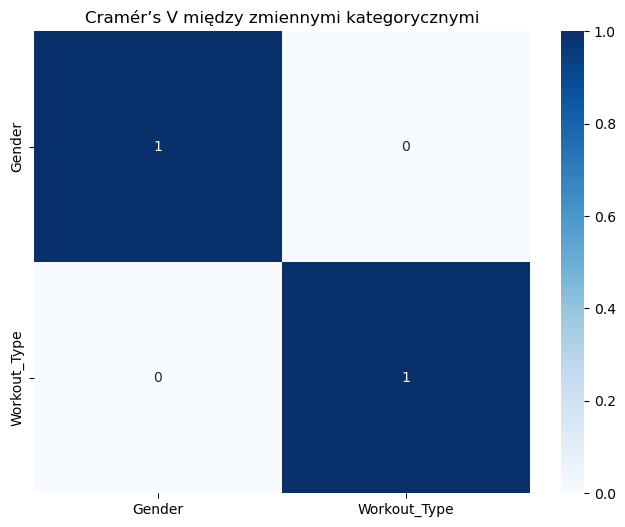

,Gender,Workout_Type
Gender,1.0,0.0
Workout_Type,0.0,1.0


In [ ]:
from correlation import cramers_v_matrix
object_cols = df_imputed.select_dtypes(include='object').columns.tolist()
cramers_v_matrix(df_imputed, object_cols)

## Mutual Information <br>

Najsilniejsza zależność z `Gender` została zauważona dla cech `Fat_Percentage` (0.41), `Water_Intake_liters` (0.39), `Weight_kg` (0.30) oraz `Height_m` (0.27). 
<br>Oznacza to, że te cechy najlepiej różnicują płeć w analizowanym zbiorze danych.
<br><br>
W przypadku `Workout_Type` wartości mutual information były znacznie niższe i zbliżone do zera, co sugeruje słabą lub brak wyraźnej zależności między cechami numerycznymi a typem treningu.

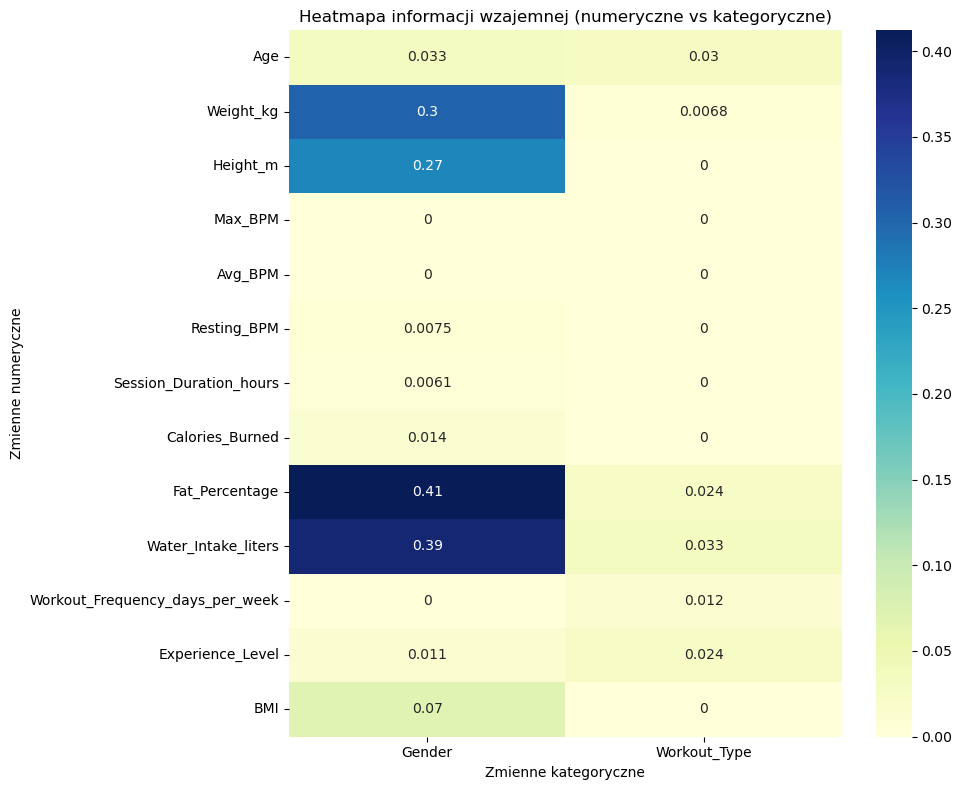

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Funkcja do obliczania informacji wzajemnej
def mutual_info_numeric_cat(df, target_cat_col):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    X = df[num_cols]
    y = df[target_cat_col].astype('category').cat.codes
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    mi_series = pd.Series(mi, index=num_cols)
    return mi_series

# Zakładamy, że df_imputed istnieje i zawiera dane
# Zidentyfikuj zmienne kategoryczne
cat_cols = df_imputed.select_dtypes(include=['object', 'category']).columns

# Tworzymy pustą ramkę danych na macierz informacji wzajemnej
mi_matrix = pd.DataFrame(index=df_imputed.select_dtypes(include=['float64', 'int64']).columns, columns=cat_cols)

# Wypełniamy macierz
for cat_col in cat_cols:
    mi_scores = mutual_info_numeric_cat(df_imputed, cat_col)
    mi_matrix[cat_col] = mi_scores

# Rysujemy heatmapę
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix.astype(float), annot=True, cmap="YlGnBu", vmin=0)
plt.title("Heatmapa informacji wzajemnej (numeryczne vs kategoryczne)")
plt.xlabel("Zmienne kategoryczne")
plt.ylabel("Zmienne numeryczne")
plt.tight_layout()
plt.show()

## Korelacja Kendall'a <br>

Zmienne Badane:  Calories_Burned, Age, Gender, Water_Intake, Fat_Percentage , BMI

- **Gender**
  Jest skorelowana z `Water_Itake_liters` - 0.39, `Fat_Percentage`-0.41, `Weight_m` -0.3, `Height_kg` - 0.27. Co zaskakujące korelacja z `BMI` wynosi tylko 0.07.<br>
- **Workout_Type**
  Brak korelacji między zmiennymi


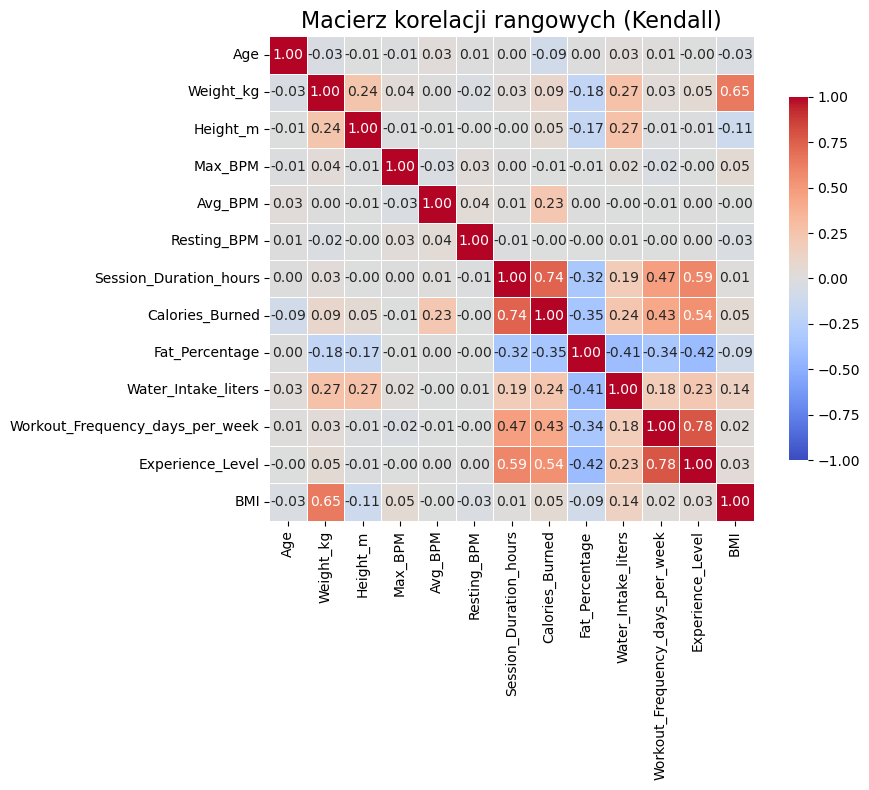

In [ ]:
corr_kendall = df_imputed.corr(method='kendall', numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_kendall,            # używamy corr_kendall, nie corr
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .75})

plt.title("Macierz korelacji rangowych (Kendall)", fontsize=16)
plt.tight_layout()
plt.show()

## Wnioski

### Główne Pytania Badawcze:
1. **Czy istnieje korelacja między `Workout_Type` a jakąkolwiek zmienną? <br>**
    Nie ma statystycznie istotnej korelacji między '`Workout_Type`' a żadną inną zmienną.<br>

2. **Jakie osoby chodzą na poszczególne typy zajęć?<br>**
    Patrzą na wszystkie grupy wieku najpopularnijszy wśród kobiet jest Strething, natomiast u mezczyzn Cardio.<br>

    Kobiety w wieku około 50 lat preferują HIIT (High Intensity Interval Training),<br>
    Strenght i Yoga jest porównywalnie popularny w grupach kobiet  20-30 oraz 40-50.<br>
    Cardio jest popularne zwłaszcza u kobiet w wieku 30-40 lat. <br>

    Mężczyźni w wieku około 40 lat wybierają najczęściej ćwiczenia Cardio.<br>
    W wieku 40-50 lat wzrasta zainteresowanie Strength jak i Jogą.<br>

3. **Czy BMI i procentowa zawartość tłuszczu różni się między kobietami a mężczyznami?** <br>
    Widoczna jest różnica pomiędzy procentową zawartością tłuszczu - kobiety mają większą tkankę tłuszczową.<br>
    Zauważono częściowo "naprzemienny" rozkład procent tłuszczu w zależności od płci. Może to wynikać z przygotowania przez autora danych wejściowych. <br>

    BMI kobiet chodzących na siłownie jest silnie skupione (std = 4.4) wokół mediany = 22.875. - Oznacza to że kobiety częściej mają podobne BMI<br>
    BMI mężczyzn jest mniej skupione (std = 7.6) wokół mediany  26.220 .<br>


### Poboczne pytania:

1. **Czy tętno spoczynkowe zmienia się wraz z wiekiem?**<br>
    Zauważono wzrost tętna spoczynkowego w grupie wiekowej 46-55 lat. Za to po tym wieku tętno spoczynkowe zaczyna maleć. <br>

2. **Czy osoby z większym procentem tkanki tłuszczowej szybciej spalają kalorie? <br>**
    Zauważono, że osoby z większą procentową ilością tkanki tłuszczowej spalają mniej kalorii.<br>


3. **Czy osoby z mniejszym procentem tkanki tłuszczowej piją więcej wody?<br>**
    Zauważono korelację pomiędzy Fat_Percentage i Spożyciem wody. <br>
    Osoby z mniejszym procentem tkanki tłuszczowej piją większe ilości wody

